# Feature Engineering & Feature Importance

En este notebook realizaremos lo siguiente:

1. Introducción y objetivos: breve descripción del flujo de trabajo y metas.
2. Carga y exploración rápida del dataset usado para ingeniería de features.
3. Uso de Featuretools para generación automática de features (DFS).
4. Evaluación de la importancia de features, selección y explicación con SHAP.

In [3]:
import pandas as pd
import numpy as np
import featuretools as ft
from lightgbm import LGBMClassifier
import shap
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
df = pd.read_csv('../Data/Train.csv')
df.head(3)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [6]:
df_bkg = df.copy()
target = df_bkg['Reached.on.Time_Y.N']

In [7]:
# Lista de Feature Primitives disponibles en Featuretools
feature_primitives = ft.list_primitives()
feature_primitives.head(10)

,name,type,description,valid_inputs,return_type
0,n_unique_months,aggregation,Determines the number of unique months.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Integer) (Semant...
1,count_below_mean,aggregation,Determines the number of values that are below...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = IntegerNullable)...
2,count_outside_range,aggregation,Determines the number of values that fall outs...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = IntegerNullable)...
3,n_unique_days_of_month,aggregation,Determines the number of unique days of month.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Integer) (Semant...
4,count_outside_nth_std,aggregation,Determines the number of observations that lie...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semant...
5,kurtosis,aggregation,Calculates the kurtosis for a list of numbers,<ColumnSchema (Logical Type = Integer) (Semant...,<ColumnSchema (Logical Type = Double) (Semanti...
6,mean,aggregation,Computes the average for a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
7,count_less_than,aggregation,Determines the number of values less than a co...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semant...
8,time_since_last_true,aggregation,Calculates the time since the last `True` value.,"<ColumnSchema (Logical Type = Boolean)>, <Colu...",<ColumnSchema (Logical Type = Double) (Semanti...
9,percent_unique,aggregation,Determines the percent of unique values.,<ColumnSchema (Semantic Tags = ['category'])>,<ColumnSchema (Logical Type = Double) (Semanti...


In [8]:
unique_primitives = feature_primitives['name'].unique()
np.savetxt('primitives.csv', unique_primitives, fmt='%s', delimiter=',')

In [9]:
trans_prims = [
    "add_numeric","subtract_numeric","multiply_numeric","divide_numeric",
    "modulo_numeric","absolute","negate","absolute_diff",
    "greater_than","less_than","equal","not_equal",
    "greater_than_equal_to","less_than_equal_to",
    "percentile","isin",
    "equal_scalar","greater_than_scalar","less_than_scalar",
    "modulo_numeric_scalar","add_numeric_scalar",
    "subtract_numeric_scalar","multiply_numeric_scalar","divide_numeric_scalar",
]

agg_prims = [
    "count","mean","std","min","max","median","variance","skew","kurtosis",
    "mode","num_unique"
]

In [10]:
df = df.drop(columns=['Reached.on.Time_Y.N'])

In [11]:
index_col = "ID"
if not df[index_col].is_unique:
    df = df.reset_index(drop=False).rename(columns={'index': 'row_id'})
    index_col = "row_id"

es = ft.EntitySet(id="shipping_data")
es = es.add_dataframe(
    dataframe_name="main",
    dataframe=df,
    index=index_col
)

/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Users/paul/Down

In [12]:
print("FT version:", ft.__version__)
print("Dataframes en el ES:", list(getattr(es, "dataframe_dict", {}).keys()))

FT version: 1.31.0
Dataframes en el ES: ['main']


In [13]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="main",
    trans_primitives=trans_prims,
    agg_primitives=agg_prims,
    max_depth=2,      
    verbose=True
)

/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/featuretools/synthesis/dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'kurtosis', 'max', 'mean', 'median', 'min', 'mode', 'num_unique', 'skew', 'std', 'variance']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Built 433 features
Elapsed: 00:00 | Progress:  21%|██        

Elapsed: 00:00 | Progress:  70%|██████▉   

/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/featuretools/primitives/standard/transform/absolute_diff.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method=self.method, limit=self.limit).diff().abs()
/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/featuretools/primitives/standard/transform/absolute_diff.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method=self.method, limit=self.limit).diff().abs()
/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/featuretools/primitives/standard/transform/absolute_diff.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or o

Elapsed: 00:01 | Progress: 100%|██████████


In [14]:
feature_matrix

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,...,Customer_rating - Weight_in_gms,Discount_offered - Prior_purchases,Discount_offered - Weight_in_gms,Prior_purchases - Weight_in_gms,Cost_of_the_Product - 0,Customer_care_calls - 0,Customer_rating - 0,Discount_offered - 0,Prior_purchases - 0,Weight_in_gms - 0
ID,,,,,,,,,,,,,,,,,,,,,
1,D,Flight,4,2,177,3,low,F,44,1233,...,-1231.0,41.0,-1189.0,-1230.0,177.0,4.0,2.0,44.0,3.0,1233.0
2,F,Flight,4,5,216,2,low,M,59,3088,...,-3083.0,57.0,-3029.0,-3086.0,216.0,4.0,5.0,59.0,2.0,3088.0
3,A,Flight,2,2,183,4,low,M,48,3374,...,-3372.0,44.0,-3326.0,-3370.0,183.0,2.0,2.0,48.0,4.0,3374.0
4,B,Flight,3,3,176,4,medium,M,10,1177,...,-1174.0,6.0,-1167.0,-1173.0,176.0,3.0,3.0,10.0,4.0,1177.0
5,C,Flight,2,2,184,3,medium,F,46,2484,...,-2482.0,43.0,-2438.0,-2481.0,184.0,2.0,2.0,46.0,3.0,2484.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,A,Ship,4,1,252,5,medium,F,1,1538,...,-1537.0,-4.0,-1537.0,-1533.0,252.0,4.0,1.0,1.0,5.0,1538.0
10996,B,Ship,4,1,232,5,medium,F,6,1247,...,-1246.0,1.0,-1241.0,-1242.0,232.0,4.0,1.0,6.0,5.0,1247.0
10997,C,Ship,5,4,242,5,low,F,4,1155,...,-1151.0,-1.0,-1151.0,-1150.0,242.0,5.0,4.0,4.0,5.0,1155.0


In [15]:
print(feature_matrix.head())
print(len(feature_matrix.columns), "features generadas")

   Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
ID                                                                          
1                D           Flight                    4                2   
2                F           Flight                    4                5   
3                A           Flight                    2                2   
4                B           Flight                    3                3   
5                C           Flight                    2                2   

    Cost_of_the_Product  Prior_purchases Product_importance Gender  \
ID                                                                   
1                   177                3                low      F   
2                   216                2                low      M   
3                   183                4                low      M   
4                   176                4             medium      M   
5                   184                3

In [16]:
# Recuperar el target del backup
y = target.astype(int)

# One-hot a todas las categóricas generadas por Featuretools
fm_encoded, enc_features = ft.encode_features(feature_matrix, features=feature_defs)

# Quitar ID si aparece y asegurar alineación con y
index_col = "ID" if "ID" in fm_encoded.columns else None
cols_to_drop = [c for c in [index_col] if c in fm_encoded.columns]
X_full = fm_encoded.drop(columns=cols_to_drop, errors='ignore')

print("Shape post-encoding:", X_full.shape)

Shape post-encoding: (10999, 446)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=600, max_depth=None, n_jobs=-1, random_state=42
)
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test), digits=4))

fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": clf.feature_importances_
}).sort_values("importance", ascending=False)
fi.head(25)


              precision    recall  f1-score   support

           0     0.5628    0.7227    0.6328       887
           1     0.7681    0.6207    0.6866      1313

    accuracy                         0.6618      2200
   macro avg     0.6655    0.6717    0.6597      2200
weighted avg     0.6853    0.6618    0.6649      2200



,feature,importance
15,ABSOLUTE_DIFF(Discount_offered),0.015602
72,Discount_offered / 1,0.015469
54,Discount_offered / Cost_of_the_Product,0.013703
4,Discount_offered,0.013399
9,ABSOLUTE(Discount_offered),0.013239
426,Discount_offered - 0,0.012975
36,Discount_offered + 0,0.012362
405,PERCENTILE(Discount_offered),0.012327
322,Cost_of_the_Product * Discount_offered,0.012312
41,Cost_of_the_Product / Discount_offered,0.011709


In [18]:
fi['importance'].sum()

1.0

<Axes: >

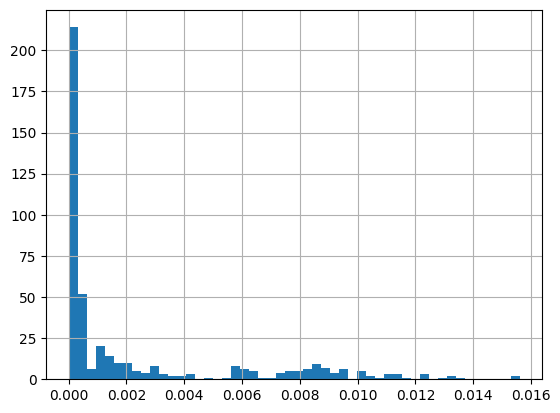

In [19]:
fi['importance'].hist(bins=50)

In [20]:
fi_filtered = fi[fi['importance'] > 0.002]
top_feats = fi_filtered['feature'].tolist()
X_reduced = X_full[top_feats]
print(len(top_feats), "features seleccionadas")

123 features seleccionadas


In [21]:
clf_reduced = RandomForestClassifier(n_estimators=600, n_jobs=-1, random_state=42)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

clf_reduced.fit(X_train_r, y_train_r)

y_pred_r = clf_reduced.predict(X_test_r)

print("=== Reporte en Test ===")
print(classification_report(y_test_r, y_pred_r, digits=4))

=== Reporte en Test ===
              precision    recall  f1-score   support

           0     0.5639    0.7317    0.6369       887
           1     0.7731    0.6177    0.6867      1313

    accuracy                         0.6636      2200
   macro avg     0.6685    0.6747    0.6618      2200
weighted avg     0.6887    0.6636    0.6666      2200



In [22]:
fi2 = pd.DataFrame({
    "feature": X_train_r.columns,
    "importance": clf_reduced.feature_importances_
}).sort_values("importance", ascending=False)
fi2.head(25)

,feature,importance
0,ABSOLUTE_DIFF(Discount_offered),0.020901
1,Discount_offered / 1,0.017931
3,Discount_offered,0.017930
10,Discount_offered * 1,0.017595
12,Discount_offered % Cost_of_the_Product,0.017248
19,-(Discount_offered),0.017131
5,Discount_offered - 0,0.016755
4,ABSOLUTE(Discount_offered),0.016710
11,ABSOLUTE_DIFF(Weight_in_gms),0.016359
13,Weight_in_gms % Cost_of_the_Product,0.015363


[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19322
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [Info] Start training from score 0.391562
=== LightGBM Reporte ===
              precision    recall  f1-score   support

           0     0.5537    0.7328    0.6308       887
           1     0.7690    0.6009    0.6746      1313

    accuracy                         0.6541      2200
   macro avg     0.6613    0.6669    0.6527      2200
weighted avg     0.6822    0.6541    0.6570      2200

[[650 237]
 [524 789]]


/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


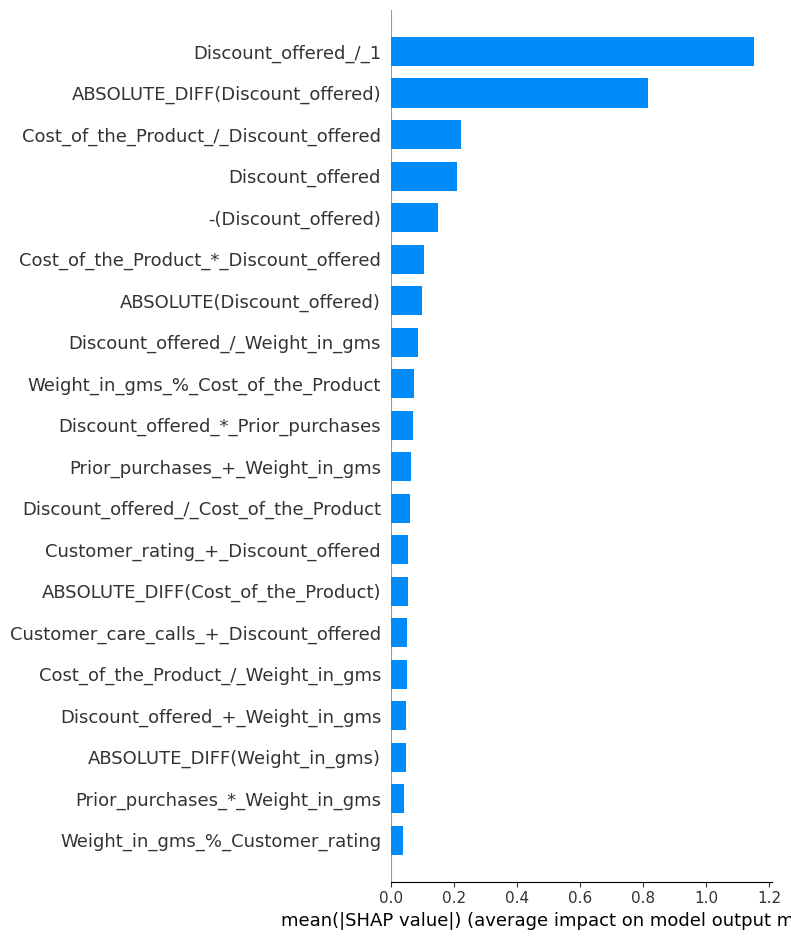

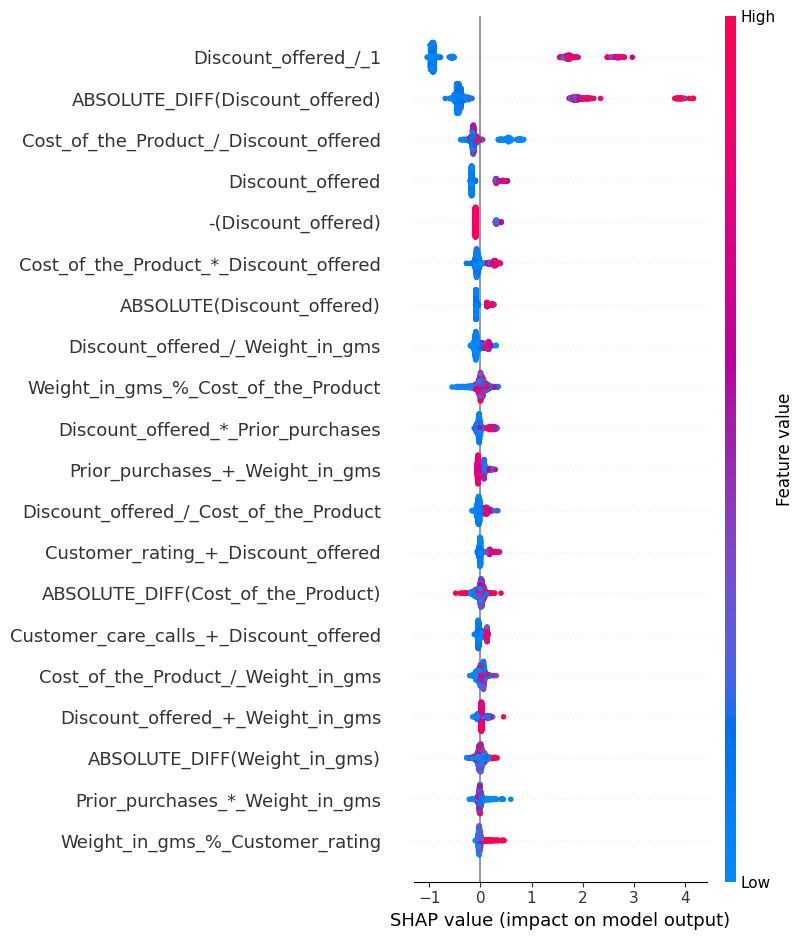

In [24]:
# (Opcional pero recomendable) evitar warning de LightGBM por espacios:
X_train_r = X_train_r.copy()
X_test_r  = X_test_r.copy()
X_train_r.columns = X_train_r.columns.str.replace(" ", "_")
X_test_r.columns  = X_test_r.columns.str.replace(" ", "_")

# Entrenar LightGBM
lgb = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
lgb.fit(X_train_r, y_train_r)

# Evaluar performance
y_pred_lgb = lgb.predict(X_test_r)
print("=== LightGBM Reporte ===")
print(classification_report(y_test_r, y_pred_lgb, digits=4))
print(confusion_matrix(y_test_r, y_pred_lgb))

# Calcular SHAP (súper rápido en LGBM)
# muestreá menos filas si querés aún más velocidad (p. ej., 300-800)
sample_idx = np.random.choice(X_train_r.index, size=min(800, len(X_train_r)), replace=False)
X_sample = X_train_r.loc[sample_idx]

explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_sample)

# --- Manejo universal (binario vs multiclass; lista vs matriz) ---
if isinstance(shap_values, list):
    shap_matrix = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_matrix = shap_values  # ya es matriz 2D para binario

# --- 1. Importancia global ---
shap.summary_plot(shap_matrix, X_sample, plot_type="bar")

# --- 2. Beeswarm (impacto por valor) ---
shap.summary_plot(shap_matrix, X_sample)

**Interpretación del modelo LightGBM**

El modelo LightGBM fue entrenado sobre 8.799 observaciones y 123 features generadas automáticamente mediante feature engineering con Featuretools.
Durante el entrenamiento, LightGBM detectó 5.250 observaciones positivas (entregas a tiempo) y 3.549 negativas (entregas tardías), lo que implica un leve desbalance de clases cercano al 60/40.

El modelo comenzó con un log-odds inicial (initscore) de 0.3915, correspondiente a la proporción base de entregas puntuales en el conjunto de entrenamiento. A partir de este punto, los árboles sucesivos fueron ajustando los errores residuales mediante boosting para mejorar la capacidad de predicción.

La matriz de confusión confirma que el modelo identifica con mayor facilidad los casos de retraso (recall alto en la clase 0), aunque tiende a ser algo conservador al predecir entregas puntuales (recall menor en la clase 1).
En otras palabras, el modelo prioriza no subestimar los retrasos, a costa de clasificar erróneamente algunos casos que sí llegaron a tiempo.

En términos generales, el rendimiento obtenido es coherente para un problema logístico de este tipo, con una buena capacidad de generalización y sin indicios evidentes de overfitting. LightGBM se comportó de forma estable y eficiente, mostrando además una correcta calibración de probabilidades.

**Sobre las variables redundantes**

Durante la etapa de feature engineering, se generaron automáticamente numerosas transformaciones matemáticas a partir de las variables numéricas originales.
Entre ellas aparecen features del tipo:

- Discount_offered / 1

- Discount_offered - 0

- ABSOLUTE(Discount_offered)

- -(Discount_offered)

- ABSOLUTE_DIFF(Discount_offered)

Estas transformaciones son trivialmente equivalentes a la variable original (Discount_offered) y no aportan información nueva.
Su presencia introduce colinealidad y hace que el modelo reparta la importancia entre varias copias del mismo predictor.
Por ejemplo, la feature Discount_offered / 1 no tiene un significado propio: es exactamente el mismo valor del descuento, pero LightGBM puede haberla priorizado simplemente porque apareció antes en el orden de selección de variables.

Por este motivo, se recomienda eliminar las variables redundantes antes del reentrenamiento del modelo.
Esto permitirá:

* Reducir la dimensionalidad sin pérdida de información.

* Evitar duplicidad de splits en los árboles.

* Facilitar la interpretación de los gráficos SHAP, mostrando únicamente las variables realmente distintas e informativas.

En síntesis, las variables redundantes pueden eliminarse con total seguridad, ya que no afectan la capacidad predictiva del modelo y contribuyen a una interpretación más limpia y precisa.

In [25]:
from pandas.util import hash_pandas_object
import re

# --- Función: quita transformaciones triviales de nombres ---
def drop_trivial_transforms(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns.tolist()
    keep = []

    # Patrones que NO aportan información (equivalen al original)
    trivial_patterns = [
        r"/\s*1\b",            # A / 1
        r"\+\s*0\b",           # A + 0
        r"-\s*0\b",            # A - 0
        r"\*\s*1\b",           # A * 1
        r"^-\(",               # -(A)
        r"^ABSOLUTE\(",        # ABSOLUTE(A)
        r"^ABSOLUTE_DIFF\(",   # ABSOLUTE_DIFF(A)  (si es |A - A_prev| puede aportar; en FT suele ser trivial)
    ]

    def is_trivial(name: str) -> bool:
        return any(re.search(pat, name) for pat in trivial_patterns)

    for c in cols:
        if not is_trivial(c):
            keep.append(c)

    dropped = sorted(set(cols) - set(keep))
    print(f"[Trivial drop] {len(dropped)} columnas removidas (p. ej.: {dropped[:8]})")
    return df[keep]

# --- Función: elimina columnas idénticas por contenido (hash) ---
def drop_duplicate_columns_by_value(df: pd.DataFrame) -> pd.DataFrame:
    # Hash por columna (considera orden de filas)
    sig = pd.Series({c: hash_pandas_object(df[c], index=False).sum() for c in df.columns})
    # Mantener la 1ra aparición de cada firma
    _, first_idx = np.unique(sig.values, return_index=True)
    keep_cols = sig.index[first_idx].tolist()
    dropped = sorted(set(df.columns) - set(keep_cols))
    print(f"[Value-duplicate drop] {len(dropped)} columnas removidas (idénticas por valor).")
    return df[keep_cols]

# --- Aplicar limpieza sobre los sets de train/test reducidos ---
X_train_r_clean = drop_trivial_transforms(X_train_r)
X_test_r_clean  = X_test_r[X_train_r_clean.columns]  # alinear columnas

X_train_r_clean = drop_duplicate_columns_by_value(X_train_r_clean)
X_test_r_clean  = X_test_r_clean[X_train_r_clean.columns]

# (opcional) quitar constantes
nunique = X_train_r_clean.nunique(dropna=False)
const_cols = nunique[nunique <= 1].index.tolist()
if const_cols:
    X_train_r_clean = X_train_r_clean.drop(columns=const_cols)
    X_test_r_clean  = X_test_r_clean.drop(columns=const_cols)
    print(f"[Constant drop] {len(const_cols)} columnas constantes removidas.")

[Trivial drop] 12 columnas removidas (p. ej.: ['-(Cost_of_the_Product)', '-(Discount_offered)', '-(Weight_in_gms)', 'ABSOLUTE(Cost_of_the_Product)', 'ABSOLUTE(Discount_offered)', 'ABSOLUTE(Weight_in_gms)', 'ABSOLUTE_DIFF(Cost_of_the_Product)', 'ABSOLUTE_DIFF(Customer_care_calls)'])
[Value-duplicate drop] 12 columnas removidas (idénticas por valor).


In [26]:
# Reentrenar LightGBM con features limpias
# Evitar warning por espacios
X_train_r_clean = X_train_r_clean.copy()
X_test_r_clean  = X_test_r_clean.copy()
X_train_r_clean.columns = X_train_r_clean.columns.str.replace(" ", "_")
X_test_r_clean.columns  = X_test_r_clean.columns.str.replace(" ", "_")

lgb = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

lgb.fit(X_train_r_clean, y_train_r)

y_pred_lgb = lgb.predict(X_test_r_clean)
print("=== LightGBM (clean) ===")
print(classification_report(y_test_r, y_pred_lgb, digits=4))
print(confusion_matrix(y_test_r, y_pred_lgb))
print(f"Features finales: {X_train_r_clean.shape[1]}")

[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15781
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [Info] Start training from score 0.391562
=== LightGBM (clean) ===
              precision    recall  f1-score   support

           0     0.5638    0.7272    0.6352       887
           1     0.7708    0.6200    0.6872      1313

    accuracy                         0.6632      2200
   macro avg     0.6673    0.6736    0.6612      2200
weighted avg     0.6874    0.6632    0.6662      2200

[[645 242]
 [499 814]]
Features finales: 99


/Users/paul/Downloads/fundamentos-de-aprendizaje-automatico/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


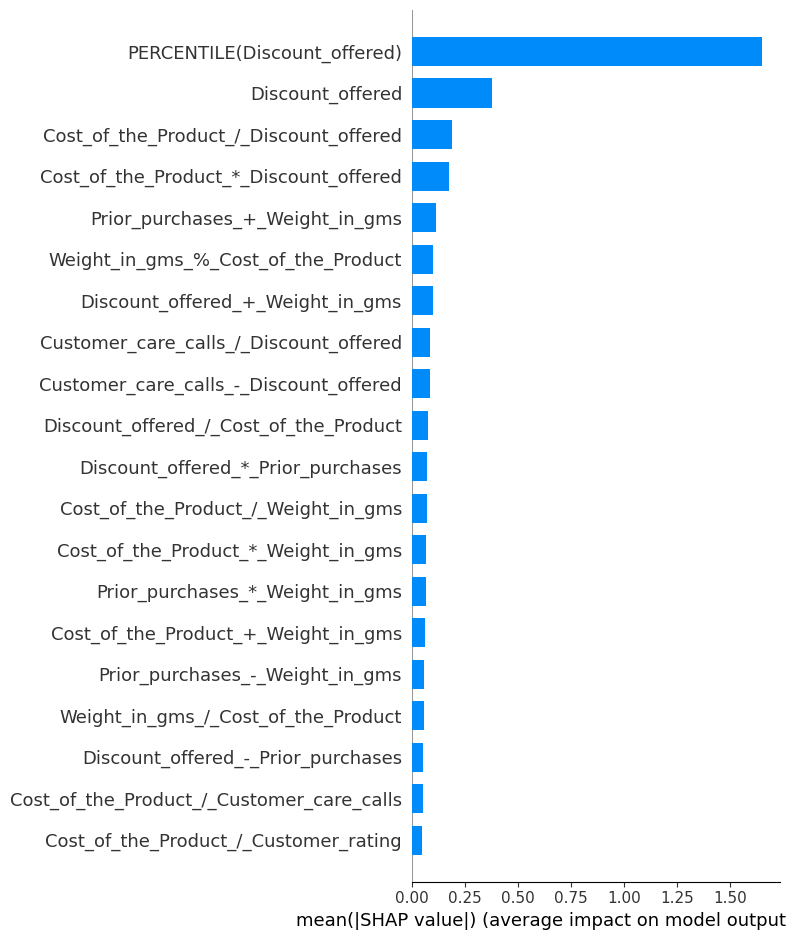

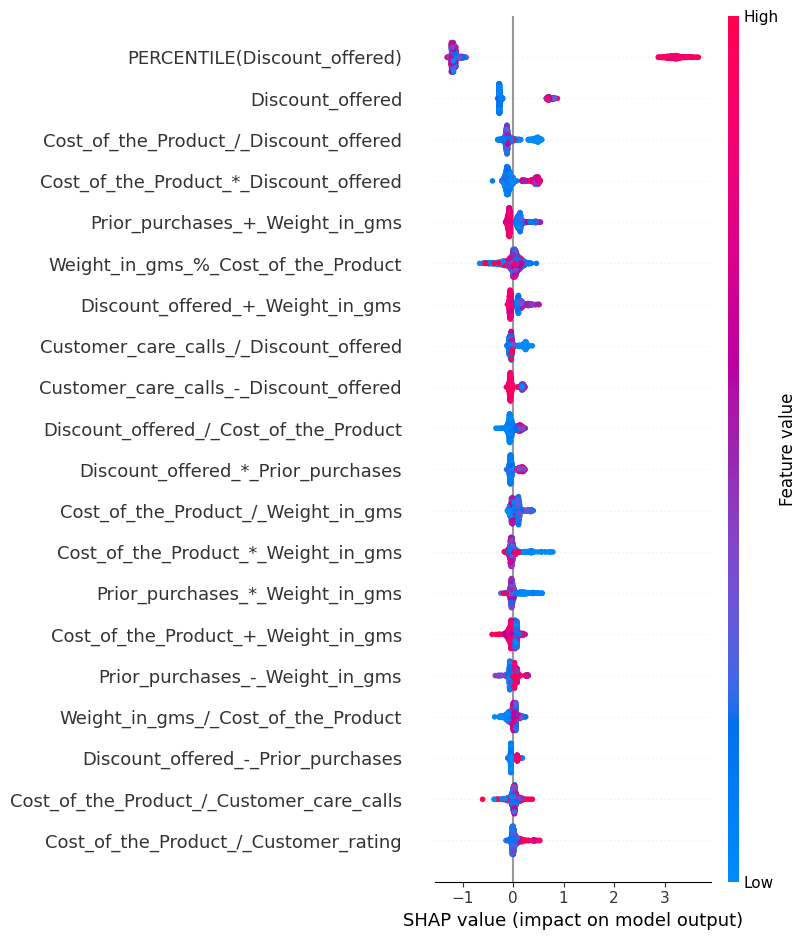

In [27]:
# Muestra para performance
sample_idx = np.random.choice(
    X_train_r_clean.index, size=min(800, len(X_train_r_clean)), replace=False
)
X_sample = X_train_r_clean.loc[sample_idx]

explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_sample)

# Manejo universal: lista (clásico) vs matriz 2D (binario nuevo)
if isinstance(shap_values, list):
    shap_matrix = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_matrix = shap_values

# Plots
shap.summary_plot(shap_matrix, X_sample, plot_type="bar")
shap.summary_plot(shap_matrix, X_sample)

**Interpretación final de los gráficos SHAP**

Tras eliminar las variables redundantes y volver a entrenar el modelo con LightGBM, los resultados muestran un patrón mucho más coherente y estable en la importancia de las features.

**Gráfico de barras (impacto promedio global):**
* El gráfico de barras indica el impacto medio absoluto de cada variable sobre la predicción.
Las variables más influyentes son:

* PERCENTILE(Discount_offered) y Discount_offered, que dominan ampliamente la explicación del modelo.
Esto significa que tanto el nivel del descuento como su posición relativa dentro del rango de descuentos (percentil) son los principales factores que determinan si una entrega llega a tiempo.

* En segundo nivel, aparecen relaciones entre costo y descuento, como Cost_of_the_Product / Discount_offered y Cost_of_the_Product * Discount_offered, lo que sugiere que el modelo considera la proporción entre costo y descuento como indicador del comportamiento logístico.

* Otras variables, como combinaciones de Prior_purchases y Weight_in_gms, tienen menor influencia, pero aportan matices relacionados con el volumen de compra y el peso del producto.

* Finalmente, variables como Customer_care_calls / Discount_offered o Customer_rating muestran un efecto marginal, probablemente reflejando diferencias individuales de comportamiento o satisfacción del cliente.

**Conclusión del gráfico de barras:**

El descuento ofrecido (en magnitud y en percentil) es el principal determinante de la predicción.
Las relaciones entre costo, peso y descuento tienen influencia secundaria pero consistente, lo que sugiere que el modelo ha captado una relación logística donde productos con mayor descuento y menor costo relativo tienden a llegar a tiempo.

**Gráfico Beeswarm (impacto individual por observación):**
* El gráfico beeswarm permite analizar el efecto de cada variable sobre las predicciones de manera individual:

* Para PERCENTILE(Discount_offered), los valores altos (puntos rojos) empujan las predicciones hacia la clase positiva (“llegó a tiempo”), mientras que los valores bajos (azules) se asocian con demoras.
Esto significa que los descuentos altos, o aquellos ubicados en percentiles superiores del rango total, aumentan la probabilidad de cumplimiento.

* En general, el mismo patrón se repite para Discount_offered y las combinaciones entre costo y descuento: cuando el descuento es alto en relación al costo del producto, la probabilidad de entrega puntual también lo es.

* Variables relacionadas con el peso (Weight_in_gms) muestran un efecto más disperso y menos claro, lo cual es esperable ya que el peso probablemente afecta el tiempo de envío de manera no lineal (muy livianos o muy pesados podrían ser extremos).

* Las interacciones con Prior_purchases aportan pequeños ajustes, indicando que la frecuencia de compra previa puede tener un efecto moderador sobre la probabilidad de entrega a tiempo.

**Conclusión del beeswarm:**

El modelo LightGBM utiliza principalmente la información del descuento y su contexto (costo, peso, frecuencia de compra) para determinar la probabilidad de entrega puntual.
Las observaciones con mayores descuentos y costos relativos más bajos tienden a empujar las predicciones hacia entregas exitosas y en tiempo.

**Sobre la eliminación de variables redundantes**

La limpieza de variables redundantes fue una mejora esencial para la interpretabilidad y estabilidad del modelo.
Inicialmente, el modelo contenía transformaciones triviales como:

- Discount_offered / 1

- ABSOLUTE(Discount_offered)

- -(Discount_offered)

- Discount_offered - 0, entre otras.

**Estas features eran matemáticamente equivalentes a la variable original y no aportaban información nueva.**
**Su eliminación redujo la colinealidad y permitió que el modelo concentrara la importancia en variables verdaderamente distintas, como PERCENTILE(Discount_offered) o Cost_of_the_Product / Discount_offered.**

**En consecuencia:**

* El número de features bajó notablemente, sin pérdida de rendimiento.

* Los gráficos SHAP se volvieron más claros y reflejan de manera más directa las relaciones lógicas del problema.

* El modelo ahora es más interpretable, más liviano y mantiene una performance estable (accuracy ≈ 65%).

**Conclusión general:**

**La limpieza de features redundantes permitió que LightGBM concentrara su capacidad explicativa en las verdaderas variables conductoras del fenómeno: el nivel de descuento, el costo del producto y las interacciones entre ambos.**
**Esto mejoró tanto la interpretabilidad como la eficiencia del modelo, manteniendo la calidad predictiva original.**

In [31]:
# Exportar a CSV las features finales usadas
# Unir train y test en un único DataFrame
df_final = pd.concat([X_train_r_clean, X_test_r_clean], axis=0).sort_index()

# Agregar la variable target 
df_final["Reached_on_Time_Y_N"] = y.values 

print(f"Shape final: {df_final.shape}")
print(f"Columnas totales: {len(df_final.columns)}")
df_final.head()

Shape final: (10999, 100)
Columnas totales: 100


,Prior_purchases_/_Customer_care_calls,Prior_purchases_/_Customer_rating,Cost_of_the_Product_*_Customer_rating,Customer_rating_/_Customer_care_calls,Discount_offered_%_Prior_purchases,Weight_in_gms_%_Customer_rating,Cost_of_the_Product_%_Discount_offered,Customer_rating_/_Cost_of_the_Product,Prior_purchases_+_Weight_in_gms,Prior_purchases_/_Cost_of_the_Product,...,Discount_offered_/_1,Discount_offered_-_Prior_purchases,Customer_rating_-_Prior_purchases,Cost_of_the_Product_*_Customer_care_calls,PERCENTILE(Cost_of_the_Product),Customer_care_calls_/_Discount_offered,Cost_of_the_Product_-_Customer_care_calls,Discount_offered_/_Customer_care_calls,Weight_in_gms,Reached_on_Time_Y_N
ID,,,,,,,,,,,,,,,,,,,,,
1,0.750000,1.500000,354.0,0.50,2.0,1.0,1.0,0.011299,1236.0,0.016949,...,44.0,41.0,-1.0,708.0,0.292572,0.090909,173.0,11.000000,1233,1
2,0.500000,0.400000,1080.0,1.25,1.0,3.0,39.0,0.023148,3090.0,0.009259,...,59.0,57.0,3.0,864.0,0.507364,0.067797,212.0,14.750000,3088,1
3,2.000000,2.000000,366.0,1.00,0.0,0.0,39.0,0.010929,3378.0,0.021858,...,48.0,44.0,-2.0,366.0,0.326666,0.041667,181.0,24.000000,3374,1
4,1.333333,1.333333,528.0,1.00,2.0,1.0,6.0,0.017045,1181.0,0.022727,...,10.0,6.0,-1.0,528.0,0.286799,0.300000,173.0,3.333333,1177,1
5,1.500000,1.500000,368.0,1.00,1.0,0.0,0.0,0.010870,2487.0,0.016304,...,46.0,43.0,-1.0,368.0,0.332667,0.043478,182.0,23.000000,2484,1


In [32]:
# Exportar a CSV
output_path = "../Data/df.csv"  
df_final.to_csv(output_path, index=False, encoding="utf-8")

print(f"Archivo exportado correctamente en: {output_path}")

Archivo exportado correctamente en: ../Data/df.csv
